In [45]:
from statsmodels.tsa.exponential_smoothing.ets import ETSModel
from statsmodels.tsa.seasonal import seasonal_decompose
import pandas as pd
import numpy as np
from sklearn import preprocessing
import matplotlib.pyplot as plt
%matplotlib inline
plt.rc("font", size=14)
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split 
import seaborn as sns
sns.set()
sns.set(style="whitegrid", color_codes = True)
import math

In [46]:
milk_data = pd.read_csv("monthly_milk.csv")

In [47]:
milk_data.head(), milk_data.tail()

(        month  milk_prod_per_cow_kg
 0  1962-01-01                265.05
 1  1962-02-01                252.45
 2  1962-03-01                288.00
 3  1962-04-01                295.20
 4  1962-05-01                327.15,
           month  milk_prod_per_cow_kg
 163  1975-08-01                386.10
 164  1975-09-01                367.65
 165  1975-10-01                372.15
 166  1975-11-01                358.65
 167  1975-12-01                379.35)

In [48]:
milk_data = milk_data.set_index('month')
milk_data.index = pd.date_range(start= milk_data.index[0], periods = len(milk_data), freq='MS')

In [49]:
total_size = len(milk_data)
train_size = math.floor(0.8*total_size)
milk_data_train = milk_data.head(train_size)
milk_data_test = milk_data.tail(len(milk_data)-train_size)

milk_data_train.index = pd.date_range(start = milk_data_train.index[0], periods= len(milk_data_train), freq="MS")
milk_data_test.index = pd.date_range(start = milk_data_test.index[0], periods= len(milk_data_test), freq = 'MS')

In [50]:
milk_data_train.shape, milk_data_test.shape

((134, 1), (34, 1))

In [51]:
milk_data_test['milk_prod_per_cow_kg']

1973-03-01    397.35
1973-04-01    404.10
1973-05-01    430.65
1973-06-01    415.80
1973-07-01    396.45
1973-08-01    376.65
1973-09-01    352.80
1973-10-01    355.95
1973-11-01    342.00
1973-12-01    360.90
1974-01-01    372.60
1974-02-01    350.10
1974-03-01    400.05
1974-04-01    405.90
1974-05-01    436.05
1974-06-01    426.15
1974-07-01    408.60
1974-08-01    390.15
1974-09-01    366.75
1974-10-01    365.40
1974-11-01    347.85
1974-12-01    365.85
1975-01-01    375.30
1975-02-01    351.90
1975-03-01    401.40
1975-04-01    406.35
1975-05-01    434.70
1975-06-01    421.65
1975-07-01    403.20
1975-08-01    386.10
1975-09-01    367.65
1975-10-01    372.15
1975-11-01    358.65
1975-12-01    379.35
Freq: MS, Name: milk_prod_per_cow_kg, dtype: float64

Text(0.5, 1.0, 'Time Series Plot of Milk Production')

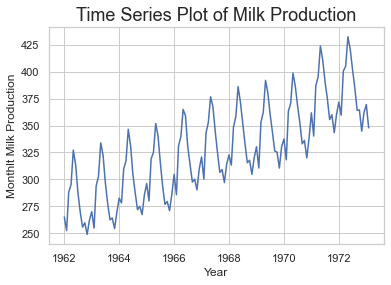

In [52]:
fig, ax = plt.subplots()
ax.plot(milk_data_train.index, milk_data_train['milk_prod_per_cow_kg'] )
ax.set_ylabel("Monthlt Milk Production")
ax.set_xlabel('Year')
ax.set_title("Time Series Plot of Milk Production", size = 18)

Text(0.5, 0, 'Year')

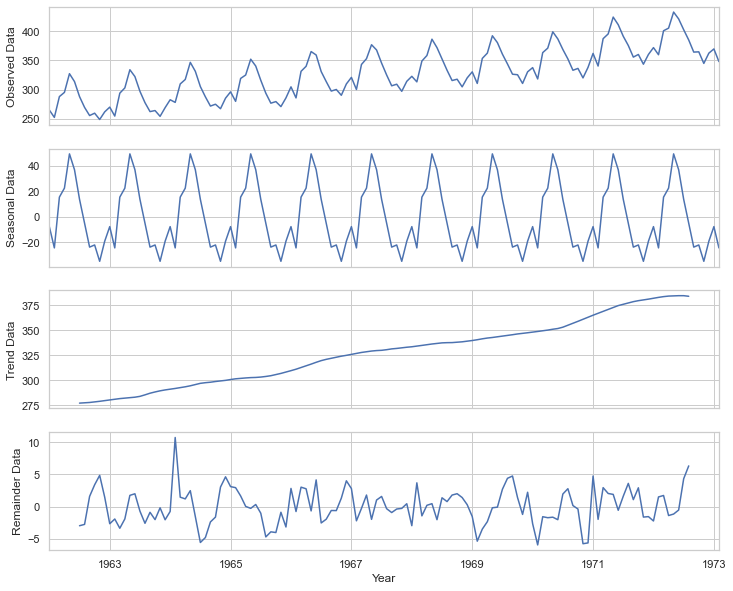

In [53]:
from statsmodels.tsa.seasonal import seasonal_decompose

res = seasonal_decompose(milk_data_train['milk_prod_per_cow_kg'], model = 'additive', period=12)

fig, (ax1, ax2, ax3, ax4) = plt.subplots(4,1, figsize=(12,10), sharex= True)
res.observed.plot(ax=ax1)
ax1.set_ylabel('Observed Data')
res.seasonal.plot(ax=ax2)
ax2.set_ylabel('Seasonal Data')
res.trend.plot(ax=ax3)
ax3.set_ylabel('Trend Data')
res.resid.plot(ax=ax4)
ax4.set_ylabel('Remainder Data')

plt.xlabel("Year")

In [54]:
milk_data_train = pd.Series(milk_data_train['milk_prod_per_cow_kg']).astype('float64')
ets_model = ETSModel(milk_data_train, error='mul', trend='add', seasonal='mul', damped_trend=True, seasonal_periods=12, initial_level=milk_data_train.values.mean(), freq='MS')
ets_fitted = ets_model.fit()

In [55]:
print(ets_fitted.summary())

                                  ETS Results                                   
Dep. Variable:     milk_prod_per_cow_kg   No. Observations:                  134
Model:                        ETS(MAdM)   Log Likelihood                -372.715
Date:                  Tue, 01 Nov 2022   AIC                            783.430
Time:                          18:53:25   BIC                            838.489
Sample:                      01-01-1962   HQIC                           805.805
                           - 02-01-1973   Scale                            0.000
Covariance Type:                 approx                                         
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
smoothing_level         0.8236      0.048     17.334      0.000       0.731       0.917
smoothing_trend         0.0152      0.012      1.252      0.211      -0.009       0.039


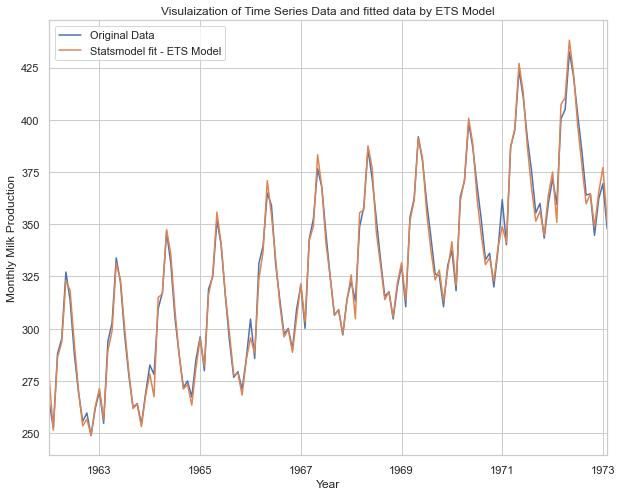

In [56]:
plt.figure(figsize=(10,8))
milk_data_train.plot(label = 'Original Data')
ets_fitted.fittedvalues.plot(label ='Statsmodel fit - ETS Model')
plt.title('Visulaization of Time Series Data and fitted data by ETS Model')
plt.ylabel('Monthly Milk Production')
plt.xlabel('Year')
plt.legend()

In [58]:
pred_ets = ets_fitted.fittedvalues

In [59]:
expected_ets = milk_data_train.values
predicted_ets = pred_ets.values

In [62]:
from sklearn.metrics import mean_squared_error
from math import sqrt
from sklearn.metrics import mean_absolute_error

def mean_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean((y_true - y_pred)/ y_true * 100)

def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs(y_true - y_pred)/ y_true * 100)

def running_diff(arr, N):
    return np.array([arr[i] - arr[i-N] for i in range(N, len(arr))])

def mean_absolute_scaled_error(training_series, testing_series, predicting_series):
    errors_mean = np.abs(testing_series - predicting_series).mean()
    d = np.abs(running_diff(training_series, 12)).mean()
    return errors_mean/d

mse_ets = mean_squared_error(expected_ets, predicted_ets)
rmse_ets = sqrt(mse_ets)
mae_ets = mean_absolute_error(expected_ets, predicted_ets)
mpe_ets = mean_percentage_error(expected_ets, predicted_ets)
mape_ets = mean_absolute_percentage_error(expected_ets, predicted_ets) 
mase_ets = mean_absolute_scaled_error(expected_ets,expected_ets, predicted_ets)


print("In Sample Error Measures of ETS Models")
print(" ")
print('- RMSE: %.2f' % rmse_ets)
print('- MAE: %.2f' % mae_ets)
print('- MPE: %.2f' % mpe_ets)
print('- MAPE: %.2f' % mape_ets)
print('- MASE: %.2f' % mase_ets)


In Sample Error Measures of ETS Models
 
- RMSE: 3.94
- MAE: 3.03
- MPE: 0.10
- MAPE: 0.92
- MASE: 0.28
